# Milestone 1: Artificial Neural Networks

Naomi Amelia

# Objective

This assignment is aimed to predict customer churning in the next quarter.

# Importing Libraries

In [285]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import pickle

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from scipy.stats import chi2_contingency
from scipy import stats 
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,roc_auc_score,precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import RandomOverSampler

np.random.seed(19)
tf.random.set_seed(19)

# Data Loading and Cleaning

In [286]:
df = pd.read_csv('telco.csv')
df.head(2).T

,0,1
customerID,7590-VHVEG,5575-GNVDE
gender,Female,Male
SeniorCitizen,0,0
Partner,Yes,No
Dependents,No,No
tenure,1,34
PhoneService,No,Yes
MultipleLines,No phone service,No
InternetService,DSL,DSL
OnlineSecurity,No,Yes


In [287]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


There are some anomalies in the data that I have seen. Including how TotalCharges is supposed to be numerical but from the info above we can see that it's in object type.

Just by looking at the info, we can see that there are no normal missing values, but we will further check this.

In [288]:
missing_values = {}

for x in list(df.columns):
    missing_values[x] = 0
    for y in df[x]:
        if y in ['N/A', '--', '-', 'Null', '?', ' ']: # These are the specific NaN values we will be sweeping for.
            missing_values[x] = missing_values[x] + 1

missing_values

{'customerID': 0,
 'gender': 0,
 'SeniorCitizen': 0,
 'Partner': 0,
 'Dependents': 0,
 'tenure': 0,
 'PhoneService': 0,
 'MultipleLines': 0,
 'InternetService': 0,
 'OnlineSecurity': 0,
 'OnlineBackup': 0,
 'DeviceProtection': 0,
 'TechSupport': 0,
 'StreamingTV': 0,
 'StreamingMovies': 0,
 'Contract': 0,
 'PaperlessBilling': 0,
 'PaymentMethod': 0,
 'MonthlyCharges': 0,
 'TotalCharges': 11,
 'Churn': 0}

It is true that the TotalCharges column has another abnormality which is non-normal missing value. Let's clean this column both from missing values and mistyping. 

In [289]:
df1 = df.loc[df['TotalCharges'] != ' ']


In [290]:
df1['TotalCharges'] = df1['TotalCharges'].astype(float)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_18136\3436144166.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['TotalCharges'] = df1['TotalCharges'].astype(float)


Then, I will be dropping the customerID column since it only acts as an identifier and does not hold any practical and beneficial factor to our analysis.

In [291]:
df1.drop(columns='customerID', inplace=True)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_18136\3815770930.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.drop(columns='customerID', inplace=True)


From here, we can move on to the exploratory data analysis.

# Exploratory Data Analysis

In this section we will be conducting visualizations of the features given as well as the target to further understand what we will be working on.

I will be changing our target with binary classes. 

In [292]:
df = df1.copy()
df.loc[:, 'Churn'] = df.loc[:, 'Churn'].replace('No', 0)
df.loc[:, 'Churn'] = df.loc[:, 'Churn'].replace('Yes', 1)
df.head(2)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0


In [293]:
df_copy = df.copy()

In [294]:
# Creating function for plotting

def barplots(features):
    plt.figure(figsize=(10, 5))
    ax = sns.barplot(data=df_copy, x=features, y='Churn', palette='rocket', ci=None)
    ax.bar_label(ax.containers[0], label_type='edge')
    plt.title('Feature Relation to Target')
    plt.ylabel('% of Churn')

## Numerical Features

In [295]:
# Grouping the numerical to certain ranges

df_copy['tenure_range'] = pd.cut(df_copy['tenure'], [0, 10, 20, 30, 40, 50, 60, 70, 80])
df_copy['monthly_Charges_range'] = pd.cut(df_copy['MonthlyCharges'], [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120])
df_copy['total_charges_range'] = pd.cut(df_copy['TotalCharges'], [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000])

# Defining numerical columns

numcols = df_copy[['tenure_range', 'monthly_Charges_range', 'total_charges_range']]


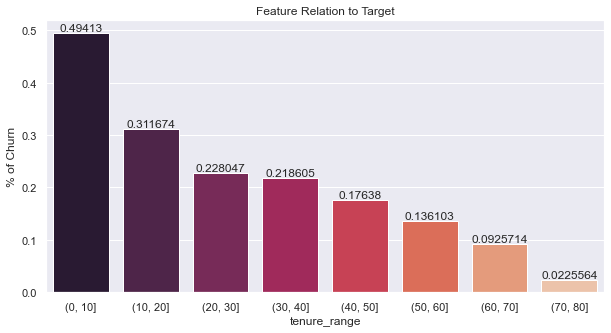

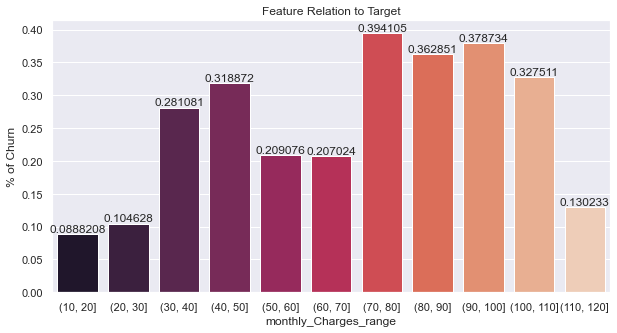

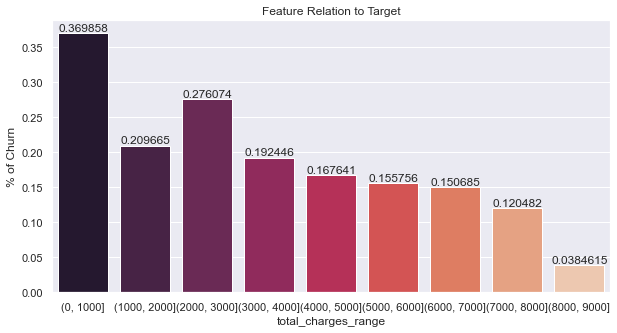

In [296]:
for features in numcols:
    barplots(features)

From the barplots, we can gain some insights that are worth taking notes for:

1. The lower the tenure is, the higher the chances of someone to churn

2. 70-110 range of months holds the highest rate of customer churning

3. The low total charges also prove that churning would be higher

## Categorical Features

In [297]:
df["SeniorCitizen"].value_counts()
df.loc[:, 'SeniorCitizen'] = df.loc[:, 'SeniorCitizen'].replace(0, 'No')
df.loc[:, 'SeniorCitizen'] = df.loc[:, 'SeniorCitizen'].replace(1, 'Yes')
df.head(2)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0


In [298]:
# defining categorical columns

catcols = df.drop(columns=['Churn', 'tenure', 'MonthlyCharges', 'TotalCharges'])

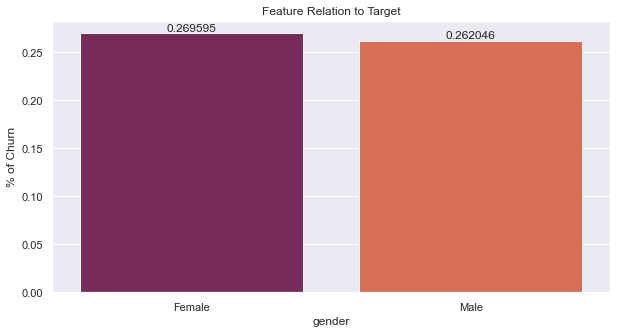

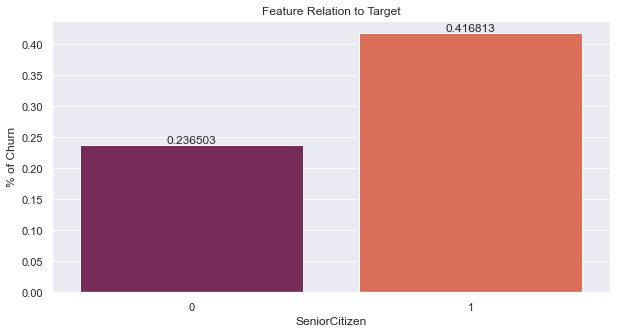

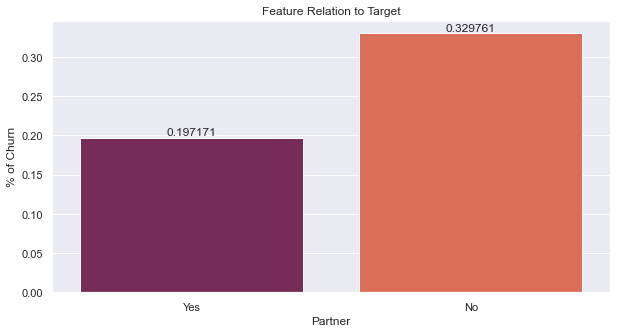

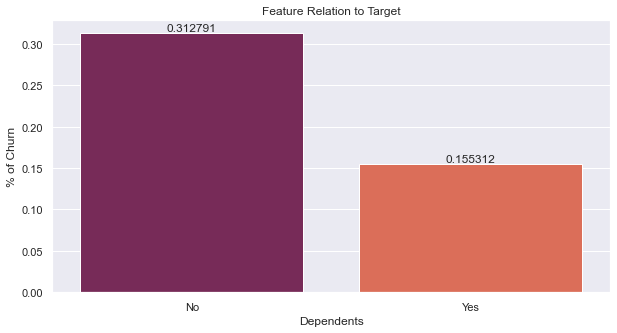

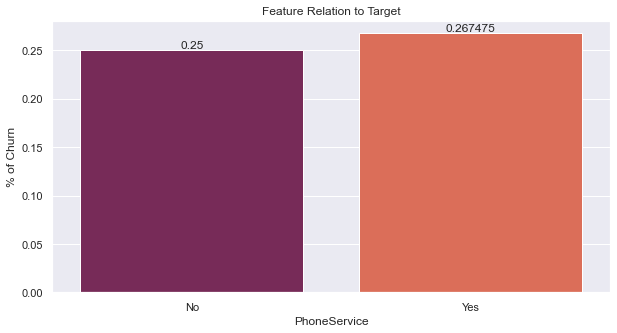

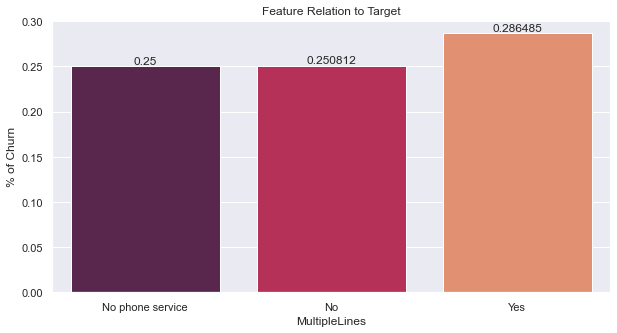

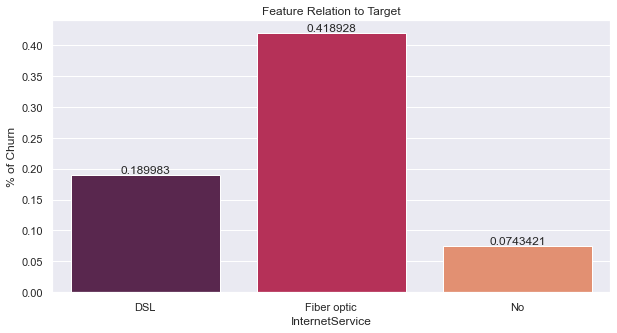

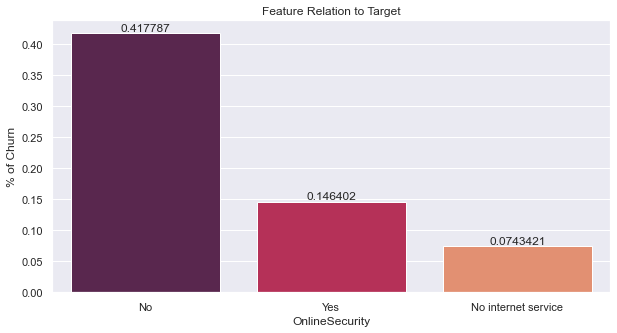

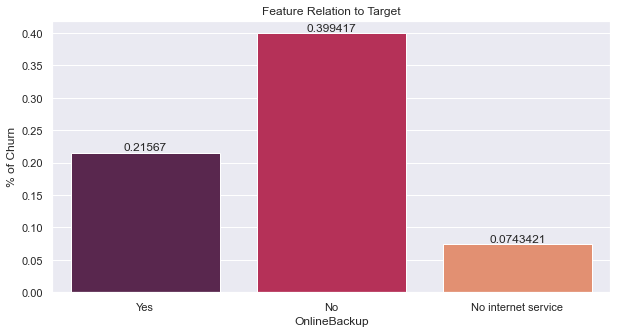

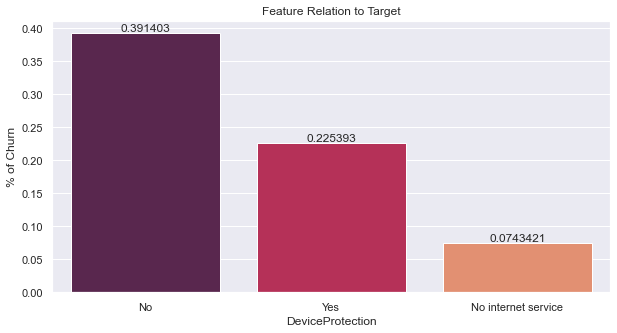

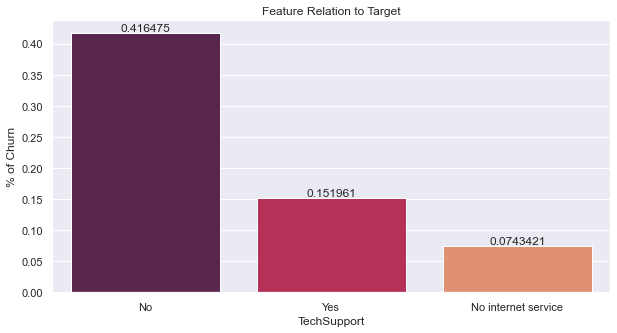

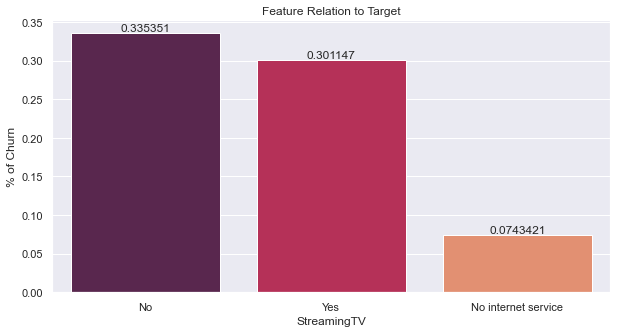

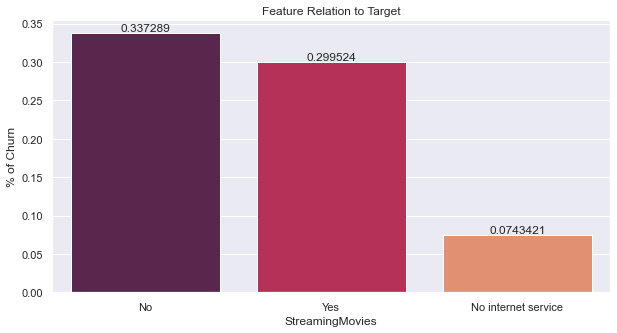

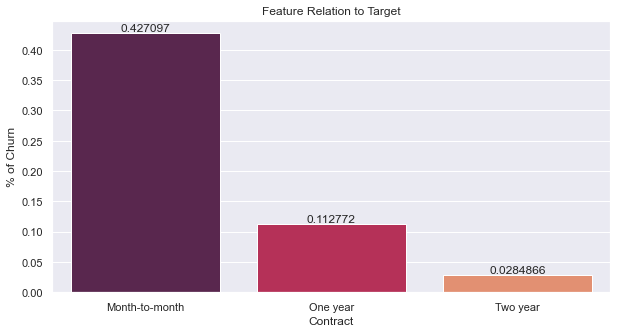

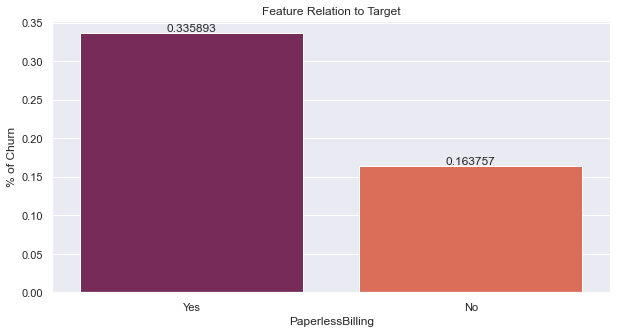

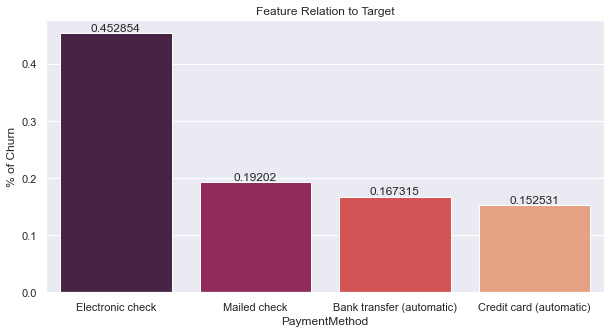

In [299]:
for features in catcols:
    barplots(features)

From the visualization of categorical features, we can gain some insights such as:

1. Female and male clients hold the same amount of values as well as the chances of them in churning
2. We can see that senior citizens tend to churn 
3. The same thing happends to those who dont have partner
4. But, for those who don't have dependents, we can see that the chances of them in churning is higher
5. We can see that whether someone has phone service and multiple lines have almost the same amount of chances of churning
6. In terms of online security and backup as well as device protection and tech support, we can see that those who do not have these features tend to churn more
7. For the ownership of movie and tv streaming, those who have and those who don't hold the same amount of churning rate.
8. The ones with month-to-month contract contrast those who have one year contract and two year contract in terms of churning
9. The same goes to those who have paperless billing
10. In detail, those who have electronic check contrast those who have mailed, bank transfer and credit card check.

# Data Preprocessing

In this section I will be conducting data preprocessing that will be used further down the line in modelling

## Handling Outlier

In this section I will be handling the outliers in the data

First, let us plot whether there are any outliers in our numerical data or not.

In [300]:
def outliers_plotting(data, feature):
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    sns.histplot(data[feature])
    plt.title('Histogram')

    plt.subplot(1, 2, 2)
    sns.boxplot(y=data[feature])
    plt.title('Boxplot')

    plt.show()

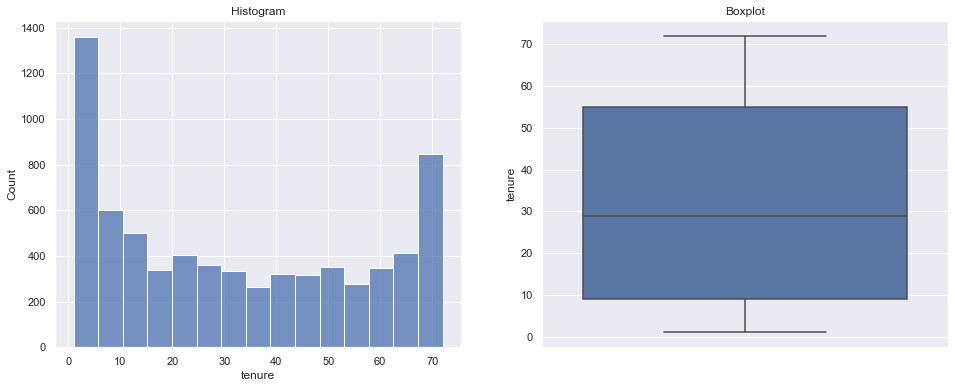

Skewness Score: 0.23773083190513133


In [301]:
outliers_plotting(df, 'tenure')
print('Skewness Score:', df['tenure'].skew())

There are no outliers in the tenure feature.

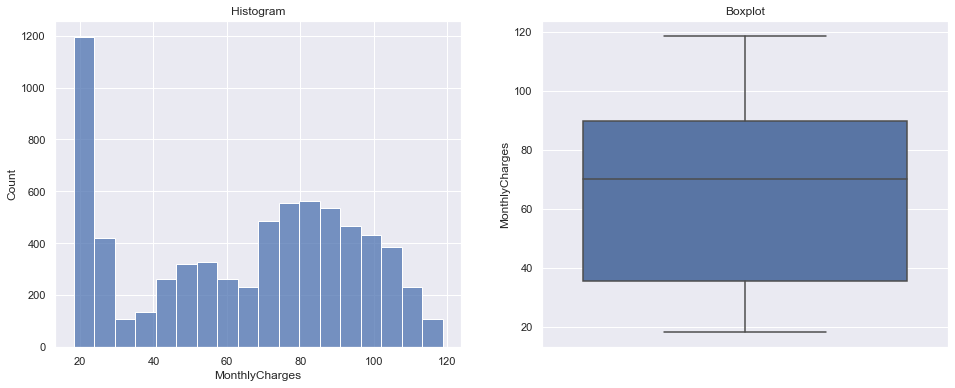

Skewness Score: -0.22210292770166232


In [302]:
outliers_plotting(df, 'MonthlyCharges')
print('Skewness Score:', df['MonthlyCharges'].skew())

There are no outliers in the MonthlyCharges feature.

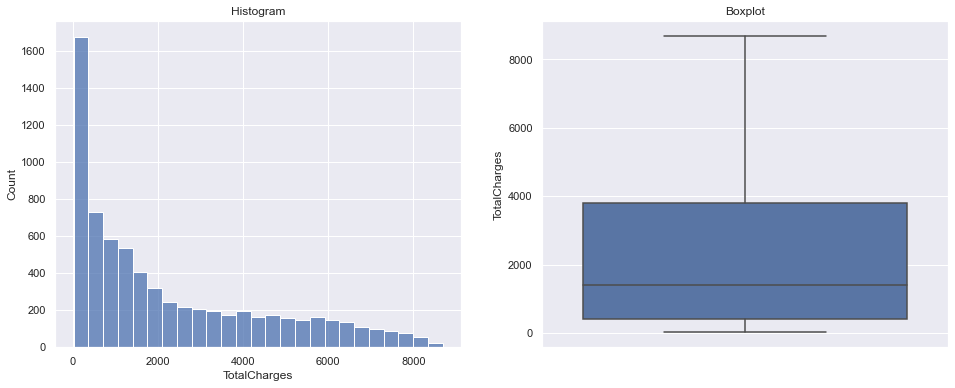

Skewness Score: 0.9616424997242504


In [303]:
outliers_plotting(df, 'TotalCharges')
print('Skewness Score:', df['TotalCharges'].skew())

Even though the TotalCharges feature is quite skewed, the skewness level is below 1 which is still in the tolerable range. 

## Feature Selection

In this section I will be analyzing which features that can be used for modelling

### Correlation

In [304]:
df_chi_numerical = df[["tenure","MonthlyCharges","TotalCharges"]]
df_chi_categorical = df.drop(["tenure","MonthlyCharges","TotalCharges","Churn"], axis=1)
df_chi_target = df[["Churn"]]

In [305]:
df_chi_target["Churn"] = df_chi_target["Churn"].astype(int)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_18136\3119089315.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chi_target["Churn"] = df_chi_target["Churn"].astype(int)


In [306]:
chi_numerical = SelectKBest(score_func=chi2, k="all")
numerical_chi_fit = chi_numerical.fit(df_chi_numerical, df_chi_target)
np.round(numerical_chi_fit.scores_)

array([ 16377.,   3653., 629631.])

In [307]:
chi_n = pd.Series((numerical_chi_fit.scores_))
chi_n.index = df_chi_numerical.columns
chi_n.sort_values(ascending=False)

TotalCharges      629630.810349
tenure             16377.328093
MonthlyCharges      3653.074681
dtype: float64

From the numerical features, we can see that all of the features holds great importance and correlation with the target. I will not be dropping the numerical features. 

Next, we will be analyzing the categorical features.

In [308]:
df_chi_categorical.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod'],
      dtype='object')

To gain the correlation of the categorical features with the target, I will encoding the these columns by ordinal encoder

In [309]:
encoder = OrdinalEncoder()
encoder.fit(df_chi_categorical)

chi_encoded = encoder.transform(df_chi_categorical)


In [310]:
chi_cat = SelectKBest(score_func=chi2, k='all')
fit_cat = chi_cat.fit(chi_encoded, df_chi_target)
np.round_(fit_cat.scores_)

array([   0.,  133.,   82.,  131.,    0.,   10.,   10.,  550.,  229.,
        191.,  522.,    7.,    8., 1112.,  105.,   59.])

In [311]:
chi_cat = pd.Series((fit_cat.scores_))
chi_cat.index = df_chi_categorical.columns
chi_cat.sort_values(ascending=False)

Contract            1111.759054
OnlineSecurity       550.437364
TechSupport          522.164716
OnlineBackup         229.441123
DeviceProtection     190.688004
SeniorCitizen        133.482766
Dependents           131.271509
PaperlessBilling     104.979224
Partner               81.857769
PaymentMethod         59.240507
MultipleLines          9.735960
InternetService        9.715269
StreamingMovies        8.357624
StreamingTV            7.373234
gender                 0.254297
PhoneService           0.092948
dtype: float64

In [312]:
def chi (features): 

  contingency_table = pd.crosstab(df[features], df["Churn"])

  stat, p, dof, expected = stats.chi2_contingency(contingency_table)
  print('p=%.3f' % (p))
  if p > 0.05:
    print("Probably Independent")
  else: 
    print("Probably Dependent")

In [313]:
for i in df_chi_categorical.columns:
    print(i)
    chi(i)
    print('-'*10)

gender
p=0.490
Probably Independent
----------
SeniorCitizen
p=0.000
Probably Dependent
----------
Partner
p=0.000
Probably Dependent
----------
Dependents
p=0.000
Probably Dependent
----------
PhoneService
p=0.350
Probably Independent
----------
MultipleLines
p=0.004
Probably Dependent
----------
InternetService
p=0.000
Probably Dependent
----------
OnlineSecurity
p=0.000
Probably Dependent
----------
OnlineBackup
p=0.000
Probably Dependent
----------
DeviceProtection
p=0.000
Probably Dependent
----------
TechSupport
p=0.000
Probably Dependent
----------
StreamingTV
p=0.000
Probably Dependent
----------
StreamingMovies
p=0.000
Probably Dependent
----------
Contract
p=0.000
Probably Dependent
----------
PaperlessBilling
p=0.000
Probably Dependent
----------
PaymentMethod
p=0.000
Probably Dependent
----------


By conducting both SelectKBest and ChiSquared, I will not be including gender and PhoneService in the feature selection

### Multicollinearity

This section is aimed to check the multicollinearity between features with the ones having high multicollinearity will be dropped.

In [314]:
ordinal = OrdinalEncoder()

# Fitting categorical columns.
ordinal.fit(df_chi_categorical[['SeniorCitizen','gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']])

# Transforming categorical columns.
df_chi_categorical[['SeniorCitizen','gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']] = ordinal.transform(df_chi_categorical
 [['SeniorCitizen','gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']])

In [315]:
df_chi_categorical = pd.DataFrame(df_chi_categorical)

df_chi = pd.concat([df_chi_numerical.reset_index(drop=True), df_chi_categorical.reset_index(drop=True)], axis=1)

Next, I will be conducting VIF testing to know which features have high multicollinearity.

In [316]:
# Checking Variance Inflation Factor (VIF)
vif_test = df_chi # Defining vif_test.
vif_data = pd.DataFrame()
vif_data["Feature"] = vif_test.columns # Creating column "Feature" in vif_data where it is equal to the entries in vif_test.

# Creating column "VIF" in vif_data where it is equal to the VIF values of each columns in vif_test.
vif_data["VIF"] = [variance_inflation_factor(vif_test.values, i) 
                          for i in range(len(vif_test.columns))]
  
print(vif_data) # Printing of output.

             Feature        VIF
0             tenure  15.084412
1     MonthlyCharges  20.503844
2       TotalCharges  13.869098
3             gender   1.954535
4      SeniorCitizen   1.369954
5            Partner   2.819229
6         Dependents   1.957360
7       PhoneService  15.150758
8      MultipleLines   2.756988
9    InternetService   4.350001
10    OnlineSecurity   2.247863
11      OnlineBackup   2.455913
12  DeviceProtection   2.629892
13       TechSupport   2.381046
14       StreamingTV   3.237958
15   StreamingMovies   3.265595
16          Contract   4.194484
17  PaperlessBilling   2.875010
18     PaymentMethod   3.095143


We can see that there are a few features that have high VIF score such as tenure, monthlycharges, totalcharges and phoneservice. But, due to the fact that tenure can have and effect on the chances of churning based on the EDA that I have conducted earlier, I will still be using tenure as a feature.

In [317]:
df = df.drop(["MonthlyCharges","TotalCharges","PhoneService","gender"], axis=1)


## Splitting the Dataframe

### Inference Data

In [318]:
df_inf = df.sample(10, random_state = 19)
df_inf

,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
3862,No,Yes,Yes,70,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
6344,Yes,Yes,No,38,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),1
2926,No,Yes,No,69,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Electronic check,0
6056,No,No,No,58,Yes,DSL,Yes,Yes,Yes,Yes,No,No,One year,Yes,Credit card (automatic),0
3799,No,No,No,31,Yes,DSL,Yes,No,Yes,Yes,No,No,Month-to-month,No,Credit card (automatic),1
6232,No,No,No,5,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,1
6763,Yes,Yes,Yes,71,Yes,DSL,No,Yes,Yes,Yes,No,Yes,One year,Yes,Bank transfer (automatic),0
6773,Yes,Yes,No,37,Yes,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,1
1878,No,No,No,3,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Credit card (automatic),0
2939,Yes,No,No,12,No,Fiber optic,No,Yes,Yes,Yes,No,No,Month-to-month,Yes,Mailed check,1


Next, I will drop the data from inference from the rest of the data that will be processed. 

In [319]:
df_tt = df.drop(df_inf.index) # df tt = dataframe for train and test
df_tt.reset_index(drop=True, inplace=True) # resetting the index fordf_tt
df_inf.reset_index(drop=True, inplace=True) # resetting the index for df_inf

### Data for Train, Test and Validation

In this section I will be splitting the df_tt to 3 groups: train, test and validation

In [320]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='Churn'), df['Churn'], train_size=0.85, stratify=df['Churn'])
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)

print('Data Train Size:', X_train.shape)
print('Data Test Size :', X_test.shape)
print('Data Validation Size:', X_val.shape)

Data Train Size: (4781, 15)
Data Test Size : (1055, 15)
Data Validation Size: (1196, 15)


### Numerical and Categorical Features Splitting

In [321]:
num_columns = X_train.select_dtypes(include=np.number).columns.to_list()
cat_columns = X_train.select_dtypes(include=['object', 'category']).columns.to_list()

print('Numerical Features:', num_columns)
print('Categorical Features:', cat_columns)

Numerical Features: ['tenure']
Categorical Features: ['SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


In [325]:
X_train_num = X_train[num_columns]
X_train_cat = X_train[cat_columns]

X_test_num = X_test[num_columns]
X_test_cat = X_test[cat_columns]

X_val_num = X_val[num_columns]
X_val_cat = X_val[cat_columns]

#### Feature Scaling

In this section I will be scaling the only numerical feature which is the tenure column

In [326]:
scaler = StandardScaler()
scaler.fit(X_train_num)

X_train_num_scaled = scaler.transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)
X_val_num_scaled = scaler.transform(X_val_num)

X_train_num_scaled

array([[-0.05313818],
       [ 1.62176106],
       [ 0.96814185],
       ...,
       [ 0.64133224],
       [-1.1969718 ],
       [ 0.02856423]])

#### Feature Encoding

In this section I will be encoding all of the categorical features selected.

In [327]:
enc = OrdinalEncoder()
enc.fit(X_train_cat)

X_train_cat_enc = enc.transform(X_train_cat)
X_test_cat_enc = enc.transform(X_test_cat)
X_val_cat_enc = enc.transform(X_val_cat)

X_train_cat_enc

array([[0., 1., 1., ..., 2., 0., 3.],
       [0., 0., 0., ..., 2., 0., 0.],
       [0., 1., 0., ..., 0., 1., 2.],
       ...,
       [0., 1., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 0., 2.],
       [0., 0., 0., ..., 0., 1., 0.]])

##### Combining the Numerical and Categorical Columns

In this section I will be combining the preprocessed numerical and categorical features.

In [329]:
X_train_final = np.concatenate([X_train_num_scaled, X_train_cat_enc], axis=1)
X_test_final = np.concatenate([X_test_num_scaled, X_test_cat_enc], axis=1)
X_val_final = np.concatenate([X_val_num_scaled, X_val_cat_enc], axis=1)

X_train_final_df = pd.DataFrame(X_train_final)
X_train_final_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-0.053138,0.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,0.0,3.0
1,1.621761,0.0,0.0,0.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0
2,0.968142,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,2.0,2.0,2.0,0.0,1.0,2.0
3,0.232820,0.0,1.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,3.0
4,0.151118,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,0.0,1.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4776,-1.115269,0.0,1.0,0.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,2.0
4777,-0.584204,0.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,2.0,2.0,0.0,0.0,3.0
4778,0.641332,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,2.0,2.0,2.0,0.0,1.0,1.0
4779,-1.196972,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,2.0


### Imbalance Data Handling 


Since the data is imbalanced, I will be conducting data balancing by using SMOTENC which is synthetic data. I will be applying SMOTENC to the train data.

In [330]:
smotenc = SMOTENC([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], random_state = 19)
X_train_balanced, y_train_balanced = smotenc.fit_resample(X_train_final, y_train)
y_train_balanced.value_counts()

0    3510
1    3510
Name: Churn, dtype: int64

The balancing by using SMOTENC needs us to specify which columns are the categorical ones, since the categorical features have the index from 1 until 14, that is why I inputted them in the parameter.

In [333]:
X_train_balanced_df = pd.DataFrame(X_train_balanced)
X_train_balanced_df.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-0.053138,0.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,0.0,3.0
1,1.621761,0.0,0.0,0.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0
2,0.968142,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,2.0,2.0,2.0,0.0,1.0,2.0


# MODELLING

In this section I will be conducting the model to predict customer churn by using tensorflow. This section will be divided into 2 sub-section the sequential and functional for the means of comparing which type of model works the best to predict the data. 

## Tensorflow Pipeline

In [334]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_balanced, y_train_balanced))
train_dataset = train_dataset.shuffle(buffer_size = 2000).batch(128)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test_final, y_test))
test_dataset = test_dataset.batch(128)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val_final, y_val))
val_dataset = val_dataset.batch(128)

## Sequential Model

### Base Model

In [362]:
n_neuronseqbase = (15) 

# Sequential Model Architechture
n_feature = X_train.shape[1]
model_sequential_base = Sequential()
model_sequential_base.add(Input(shape=(n_feature, )))                   # Input Layer                  
model_sequential_base.add(Dense(n_neuronseqbase, activation='relu'))    # Hidden Layer
model_sequential_base.add(Dense(1, activation='sigmoid'))               # Output Layer

In [359]:
model_sequential_base.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 15)                240       
                                                                 
 dense_9 (Dense)             (None, 1)                 16        
                                                                 
Total params: 256
Trainable params: 256
Non-trainable params: 0
_________________________________________________________________


In [363]:
model_sequential_base.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics='accuracy')
history_seqbase = model_sequential_base.fit(train_dataset, epochs=100, validation_data=(val_dataset))

Epoch 1/100
55/55 [==============================] - 1s 8ms/step - loss: 0.6677 - accuracy: 0.5803 - val_loss: 0.5581 - val_accuracy: 0.7115
Epoch 2/100
55/55 [==============================] - 0s 3ms/step - loss: 0.5905 - accuracy: 0.6960 - val_loss: 0.5512 - val_accuracy: 0.7074
Epoch 3/100
55/55 [==============================] - 0s 3ms/step - loss: 0.5559 - accuracy: 0.7288 - val_loss: 0.5329 - val_accuracy: 0.7258
Epoch 4/100
55/55 [==============================] - 0s 3ms/step - loss: 0.5310 - accuracy: 0.7484 - val_loss: 0.5235 - val_accuracy: 0.7341
Epoch 5/100
55/55 [==============================] - 0s 3ms/step - loss: 0.5191 - accuracy: 0.7477 - val_loss: 0.5247 - val_accuracy: 0.7375
Epoch 6/100
55/55 [==============================] - 0s 3ms/step - loss: 0.5127 - accuracy: 0.7514 - val_loss: 0.5234 - val_accuracy: 0.7349
Epoch 7/100
55/55 [==============================] - 0s 3ms/step - loss: 0.5063 - accuracy: 0.7618 - val_loss: 0.5207 - val_accuracy: 0.7308
Epoch 8/100
5

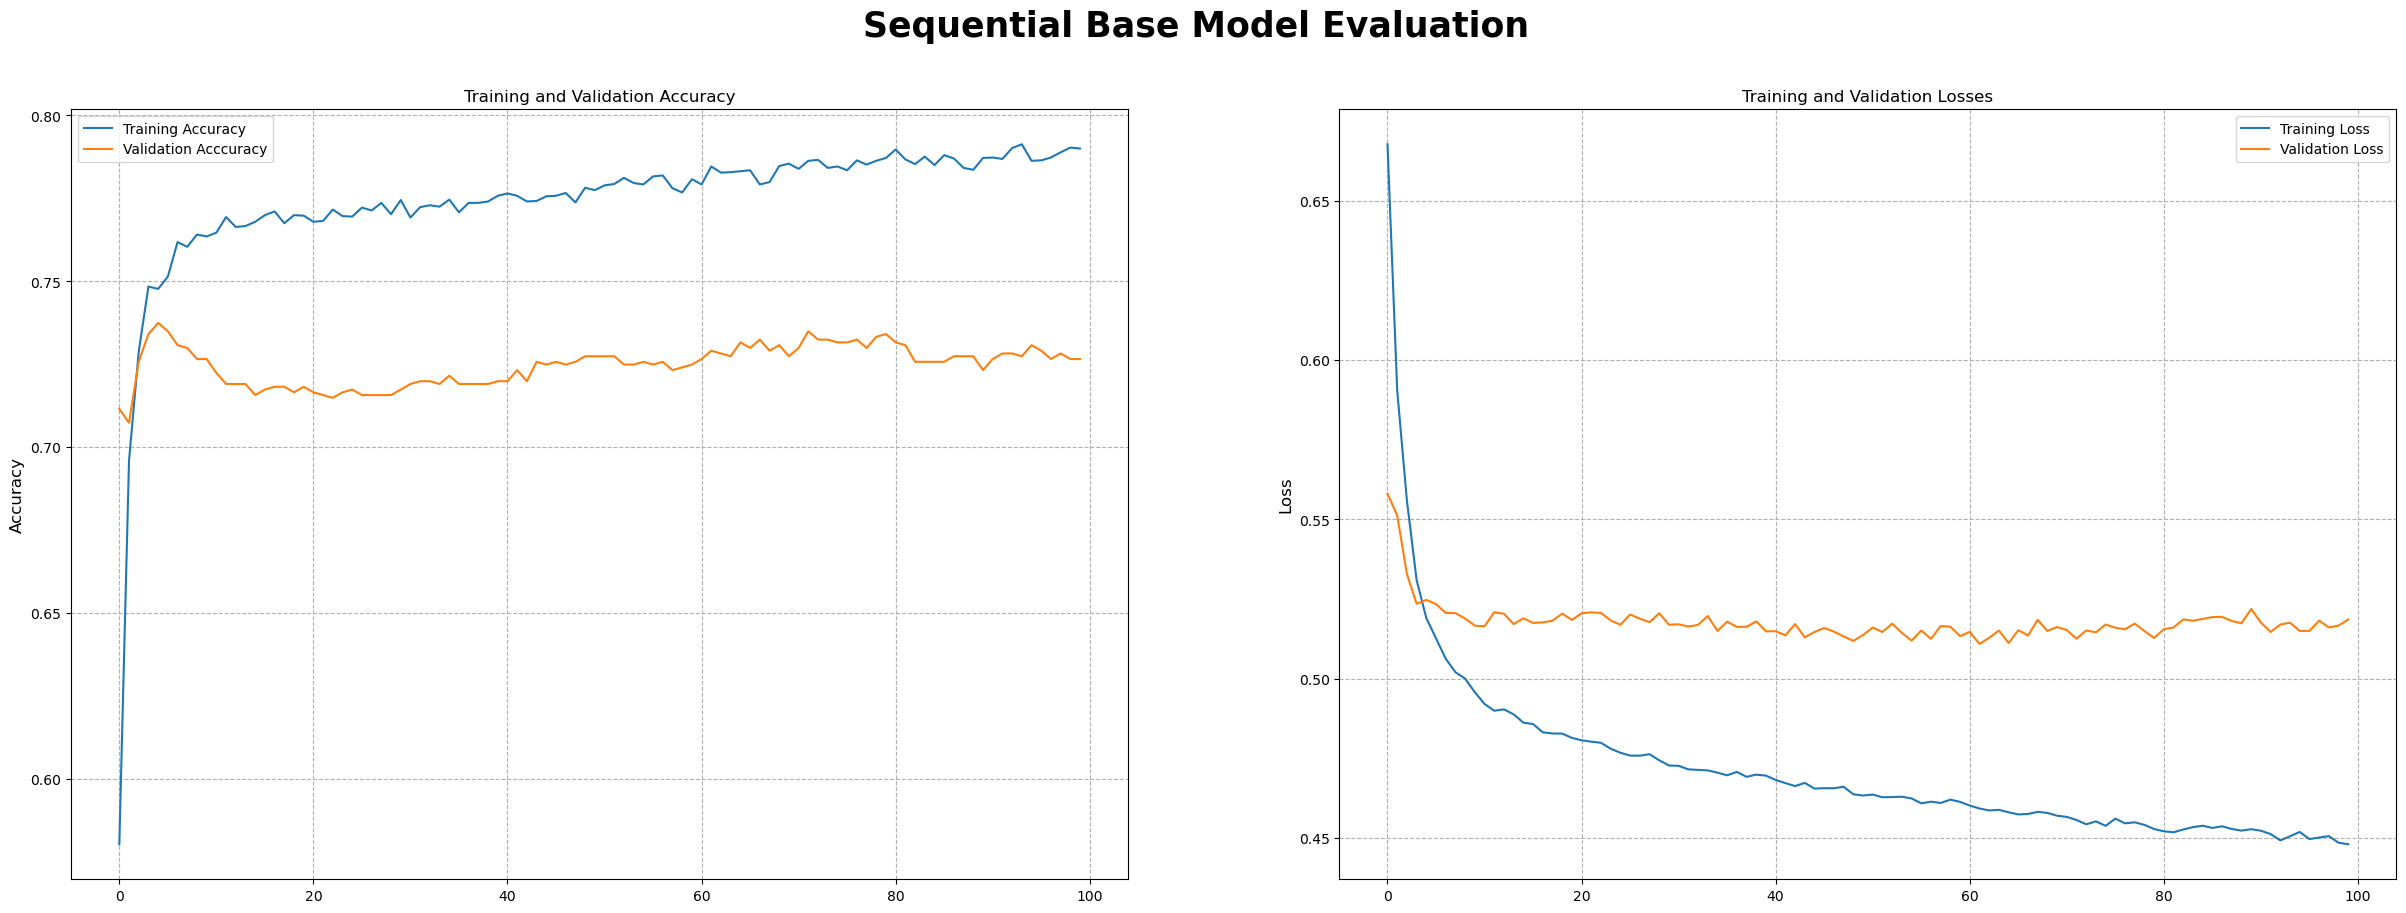

In [364]:
fig, ax = plt.subplots(1,2, figsize=(30,10))
fig.suptitle('Sequential Base Model Evaluation', fontsize=25, weight='bold')

plt.subplot(1,2,1)
plt.title("Training and Validation Accuracy", fontsize=12)
plt.plot(history_seqbase.history['accuracy'],label="Training Accuracy")
plt.plot(history_seqbase.history['val_accuracy'], label="Validation Acccuracy")
plt.ylabel("Accuracy", fontsize=12)
plt.legend()
plt.grid(linestyle='--')

plt.subplot(1,2,2)
plt.title("Training and Validation Losses", fontsize=12)
plt.plot(history_seqbase.history['loss'], label="Training Loss")
plt.plot(history_seqbase.history['val_loss'], label="Validation Loss")
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.grid(linestyle='--')

plt.style.use('default')
plt.show()

In [356]:
class stop_training(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('val_accuracy')<0.4):
            print("\nReached 69% accuracy so canceling training!")
            self.model.stop_training = True

my_callbacks = stop_training()


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=3,
                                                  restore_best_weights=True)

In [366]:
n_neuronseqbase = (15) 

# Sequential Model Architechture
n_feature = X_train.shape[1]
model_sequential_base_callback = Sequential()
model_sequential_base_callback.add(Input(shape=(n_feature, )))                   # Input Layer                  
model_sequential_base_callback.add(Dense(n_neuronseqbase, activation='relu'))    # Hidden Layer
model_sequential_base_callback.add(Dense(1, activation='sigmoid'))               # Output Layer

In [367]:
model_sequential_base_callback.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics='accuracy')
history_seqbase_callback = model_sequential_base.fit(train_dataset, epochs=500, validation_data=(val_dataset),callbacks=[early_stopping, my_callbacks])

Epoch 1/500
55/55 [==============================] - 0s 4ms/step - loss: 0.4494 - accuracy: 0.7870 - val_loss: 0.5181 - val_accuracy: 0.7266
Epoch 2/500
55/55 [==============================] - 0s 4ms/step - loss: 0.4502 - accuracy: 0.7900 - val_loss: 0.5197 - val_accuracy: 0.7258
Epoch 3/500
55/55 [==============================] - 0s 4ms/step - loss: 0.4498 - accuracy: 0.7840 - val_loss: 0.5170 - val_accuracy: 0.7283
Epoch 4/500
55/55 [==============================] - 0s 4ms/step - loss: 0.4485 - accuracy: 0.7897 - val_loss: 0.5182 - val_accuracy: 0.7274
Epoch 5/500
55/55 [==============================] - 0s 4ms/step - loss: 0.4488 - accuracy: 0.7870 - val_loss: 0.5182 - val_accuracy: 0.7274
Epoch 6/500
55/55 [==============================] - 0s 4ms/step - loss: 0.4491 - accuracy: 0.7862 - val_loss: 0.5180 - val_accuracy: 0.7283


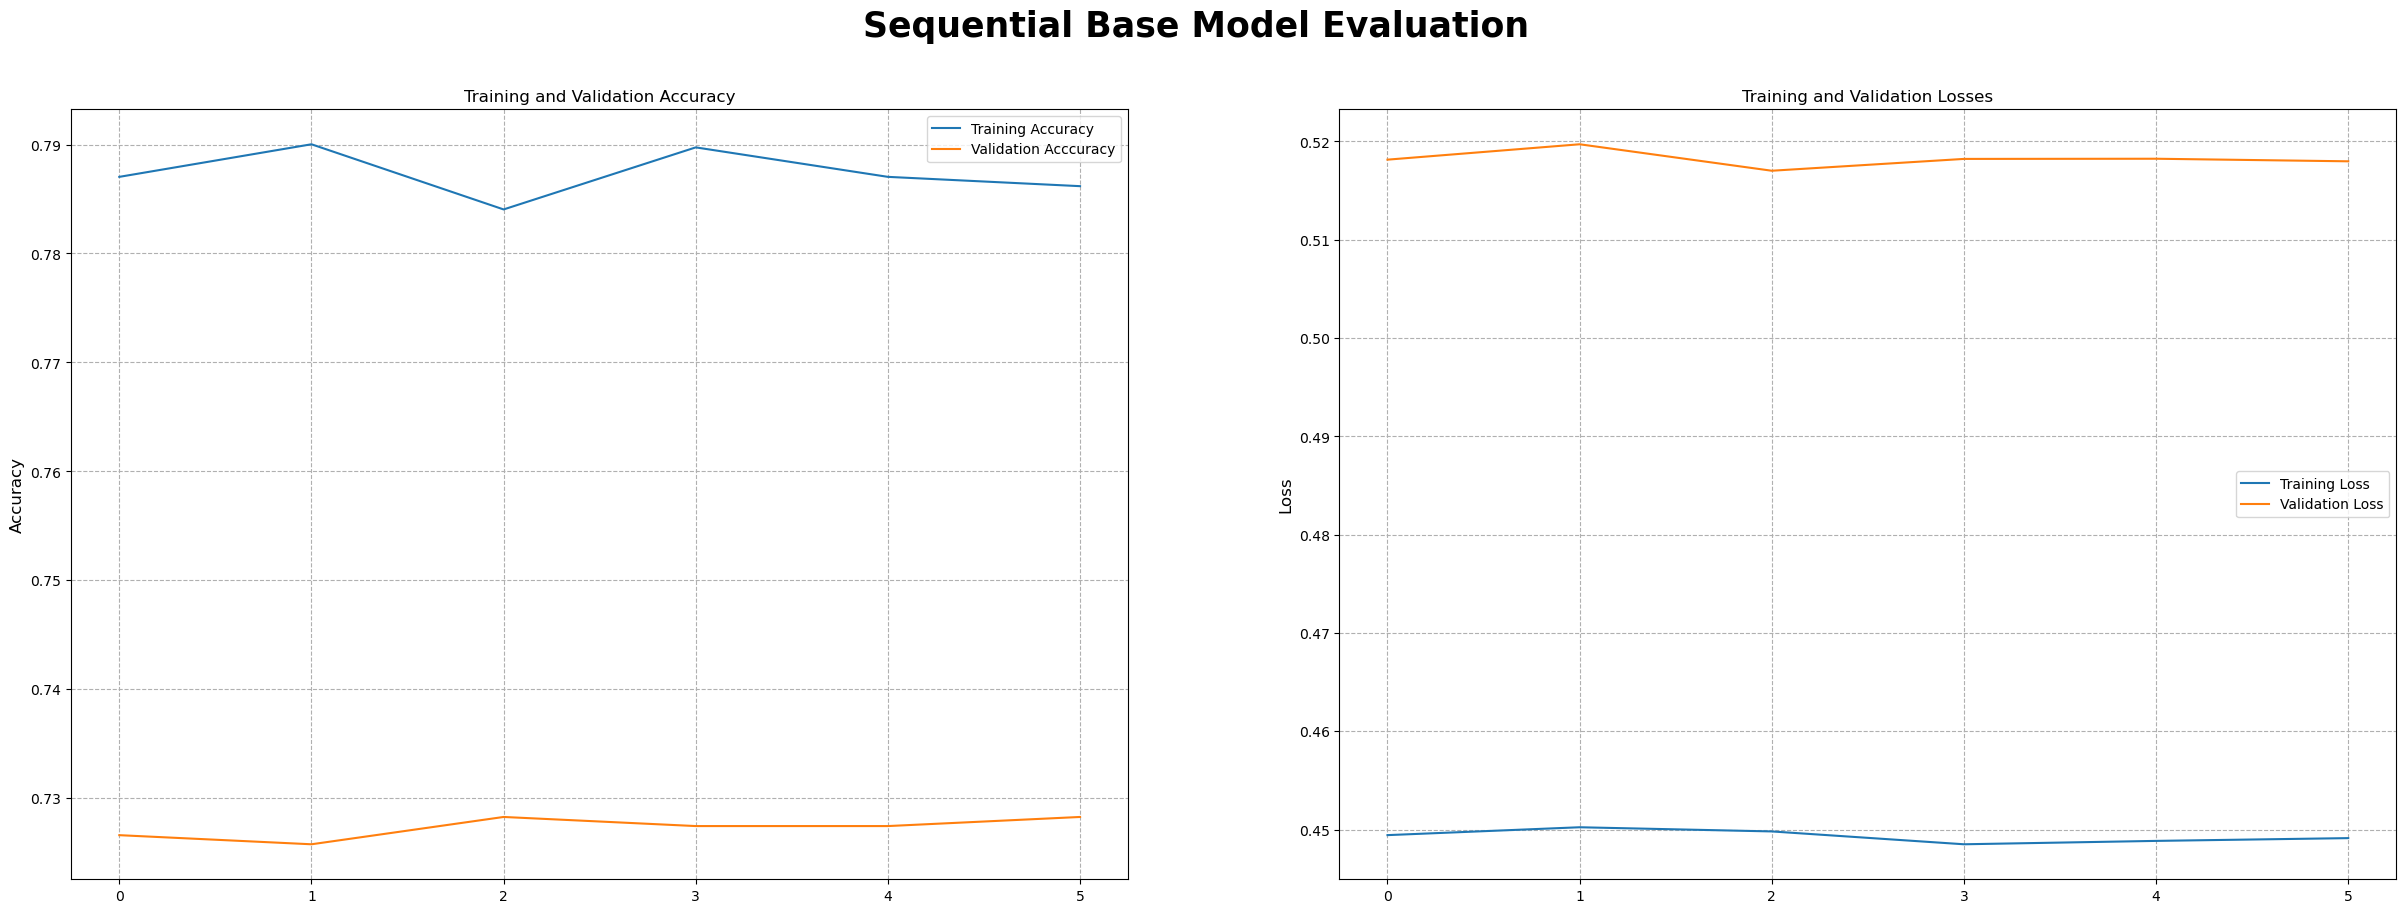

In [368]:
fig, ax = plt.subplots(1,2, figsize=(30,10))
fig.suptitle('Sequential Base Model Evaluation', fontsize=25, weight='bold')

plt.subplot(1,2,1)
plt.title("Training and Validation Accuracy", fontsize=12)
plt.plot(history_seqbase_callback.history['accuracy'],label="Training Accuracy")
plt.plot(history_seqbase_callback.history['val_accuracy'], label="Validation Acccuracy")
plt.ylabel("Accuracy", fontsize=12)
plt.legend()
plt.grid(linestyle='--')

plt.subplot(1,2,2)
plt.title("Training and Validation Losses", fontsize=12)
plt.plot(history_seqbase_callback.history['loss'], label="Training Loss")
plt.plot(history_seqbase_callback.history['val_loss'], label="Validation Loss")
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.grid(linestyle='--')

plt.style.use('default')
plt.show()

We can see that the one which uses callback is not a good model at all, thus I will be improving the base model without the callback.

#### Model Improvement

In [340]:
n_neuronseq = (16, 10)

n_feature = X_train.shape[1]
model_seq_improve = Sequential()
model_seq_improve.add(Input(shape=(n_feature, )))       # Input Layer

for n in n_neuronseq:                           # Hidden Layer
    model_seq_improve.add(Dense(n, activation='elu'))

model_seq_improve.add(Dense(1, activation='sigmoid'))   # Output Layer

In [341]:
model_seq_improve.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 16)                256       
                                                                 
 dense_6 (Dense)             (None, 10)                170       
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                                 
Total params: 437
Trainable params: 437
Non-trainable params: 0
_________________________________________________________________


In [342]:
model_seq_improve.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics='accuracy')
history_seq = model_seq_improve.fit(train_dataset, epochs=100, validation_data=(val_dataset))

Epoch 1/100
55/55 [==============================] - 1s 8ms/step - loss: 0.8504 - accuracy: 0.4943 - val_loss: 0.9982 - val_accuracy: 0.2642
Epoch 2/100
55/55 [==============================] - 0s 4ms/step - loss: 0.8025 - accuracy: 0.4940 - val_loss: 0.9173 - val_accuracy: 0.2684
Epoch 3/100
55/55 [==============================] - 0s 3ms/step - loss: 0.7611 - accuracy: 0.4994 - val_loss: 0.8469 - val_accuracy: 0.2784
Epoch 4/100
55/55 [==============================] - 0s 3ms/step - loss: 0.7259 - accuracy: 0.5125 - val_loss: 0.7878 - val_accuracy: 0.3244
Epoch 5/100
55/55 [==============================] - 0s 3ms/step - loss: 0.6965 - accuracy: 0.5430 - val_loss: 0.7384 - val_accuracy: 0.4164
Epoch 6/100
55/55 [==============================] - 0s 3ms/step - loss: 0.6724 - accuracy: 0.5934 - val_loss: 0.6971 - val_accuracy: 0.5092
Epoch 7/100
55/55 [==============================] - 0s 3ms/step - loss: 0.6518 - accuracy: 0.6412 - val_loss: 0.6640 - val_accuracy: 0.5895
Epoch 8/100
5

Next, I will be plotting the evaluation of the improved sequential model.

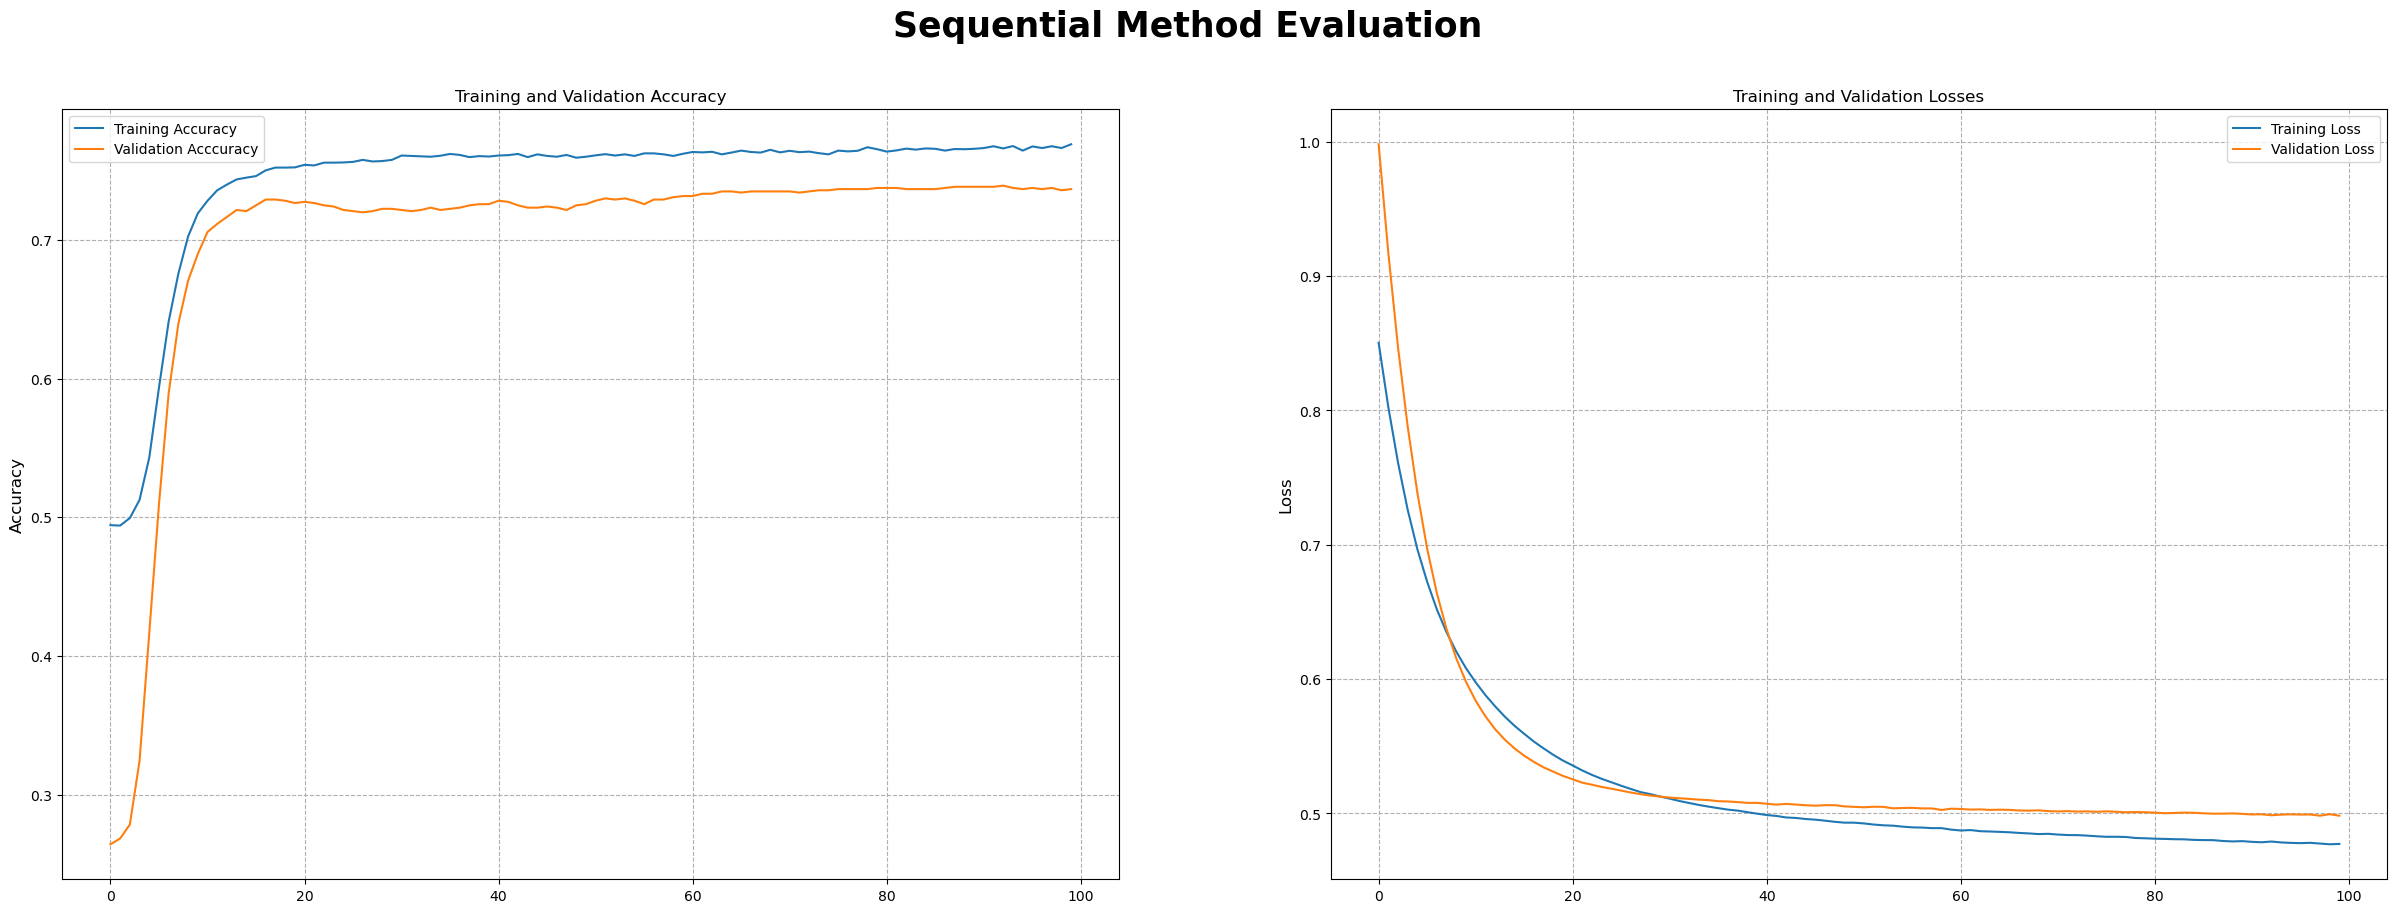

In [343]:
fig, ax = plt.subplots(1,2, figsize=(30,10))
fig.suptitle('Sequential Method Evaluation', fontsize=25, weight='bold')

plt.subplot(1,2,1)
plt.title("Training and Validation Accuracy", fontsize=12)
plt.plot(history_seq.history['accuracy'],label="Training Accuracy")
plt.plot(history_seq.history['val_accuracy'], label="Validation Acccuracy")
plt.ylabel("Accuracy", fontsize=12)
plt.legend()
plt.grid(linestyle='--')

plt.subplot(1,2,2)
plt.title("Training and Validation Losses", fontsize=12)
plt.plot(history_seq.history['loss'], label="Training Loss")
plt.plot(history_seq.history['val_loss'], label="Validation Loss")
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.grid(linestyle='--')

plt.style.use('default')
plt.show()

In [344]:
model_seq_improve.trainable = False

#### Model Evaluation

9/9 [==============================] - 0s 2ms/step
=============== TEST EVALUATION SCORE ===============
              precision    recall  f1-score   support

           0       0.92      0.63      0.75       775
           1       0.45      0.85      0.59       280

    accuracy                           0.69      1055
   macro avg       0.69      0.74      0.67      1055
weighted avg       0.80      0.69      0.71      1055



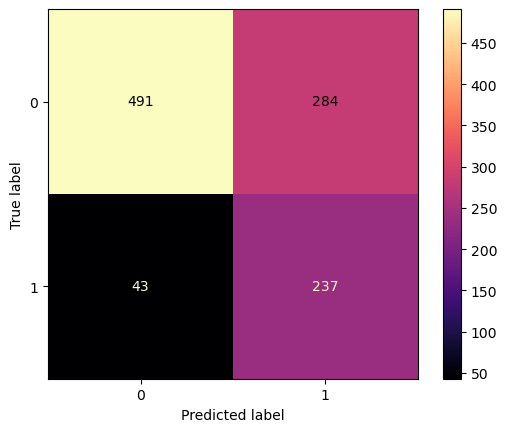

In [347]:
# predict probabilities
y_pred_seq = model_seq_improve.predict(test_dataset)
y_pred_seq = (y_pred_seq > 0.4)

# classification report
print("="*15,"TEST EVALUATION SCORE","="*15)
print(classification_report(y_test, y_pred_seq, zero_division=0))

# confusion matrix
cm = confusion_matrix(y_test, y_pred_seq)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='magma')
plt.show()

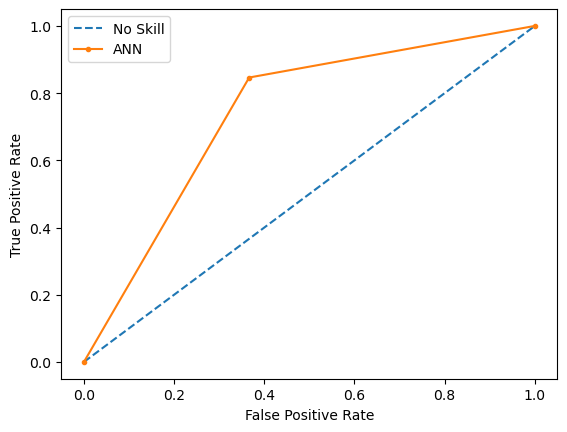

AUC score: 0.7399884792626729


In [348]:
# calculate roc curves & auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_seq)
auc = roc_auc_score(y_test, y_pred_seq)

# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='ANN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print(f'AUC score: {auc}')

## Functional Model

### Base Model 

In [370]:
n_neuronfuncbase = (15)   

# Functional Model Architechture
data_in = Input(shape=(n_feature, ))                            # Input Layer
                     
hidden_n = Dense(n_neuronfuncbase, activation='relu')(data_in) # Hidden Layer

data_out = Dense(1, activation='sigmoid')(hidden_n)             # Output Layer

model_functional_base = Model(inputs=data_in, outputs=data_out)

In [371]:
model_functional_base.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 15)]              0         
                                                                 
 dense_16 (Dense)            (None, 15)                240       
                                                                 
 dense_17 (Dense)            (None, 1)                 16        
                                                                 
Total params: 256
Trainable params: 256
Non-trainable params: 0
_________________________________________________________________


In [374]:
model_functional_base.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics='accuracy')
history_functional_base = model_functional_base.fit(train_dataset, epochs=100, validation_data=(val_dataset))

Epoch 1/100
55/55 [==============================] - 1s 7ms/step - loss: 0.4499 - accuracy: 0.7849 - val_loss: 0.5069 - val_accuracy: 0.7375
Epoch 2/100
55/55 [==============================] - 0s 3ms/step - loss: 0.4473 - accuracy: 0.7842 - val_loss: 0.5127 - val_accuracy: 0.7324
Epoch 3/100
55/55 [==============================] - 0s 3ms/step - loss: 0.4486 - accuracy: 0.7812 - val_loss: 0.5175 - val_accuracy: 0.7274
Epoch 4/100
55/55 [==============================] - 0s 3ms/step - loss: 0.4482 - accuracy: 0.7846 - val_loss: 0.5167 - val_accuracy: 0.7266
Epoch 5/100
55/55 [==============================] - 0s 3ms/step - loss: 0.4484 - accuracy: 0.7842 - val_loss: 0.5170 - val_accuracy: 0.7274
Epoch 6/100
55/55 [==============================] - 0s 3ms/step - loss: 0.4487 - accuracy: 0.7842 - val_loss: 0.5171 - val_accuracy: 0.7283
Epoch 7/100
55/55 [==============================] - 0s 3ms/step - loss: 0.4485 - accuracy: 0.7833 - val_loss: 0.5158 - val_accuracy: 0.7291
Epoch 8/100
5

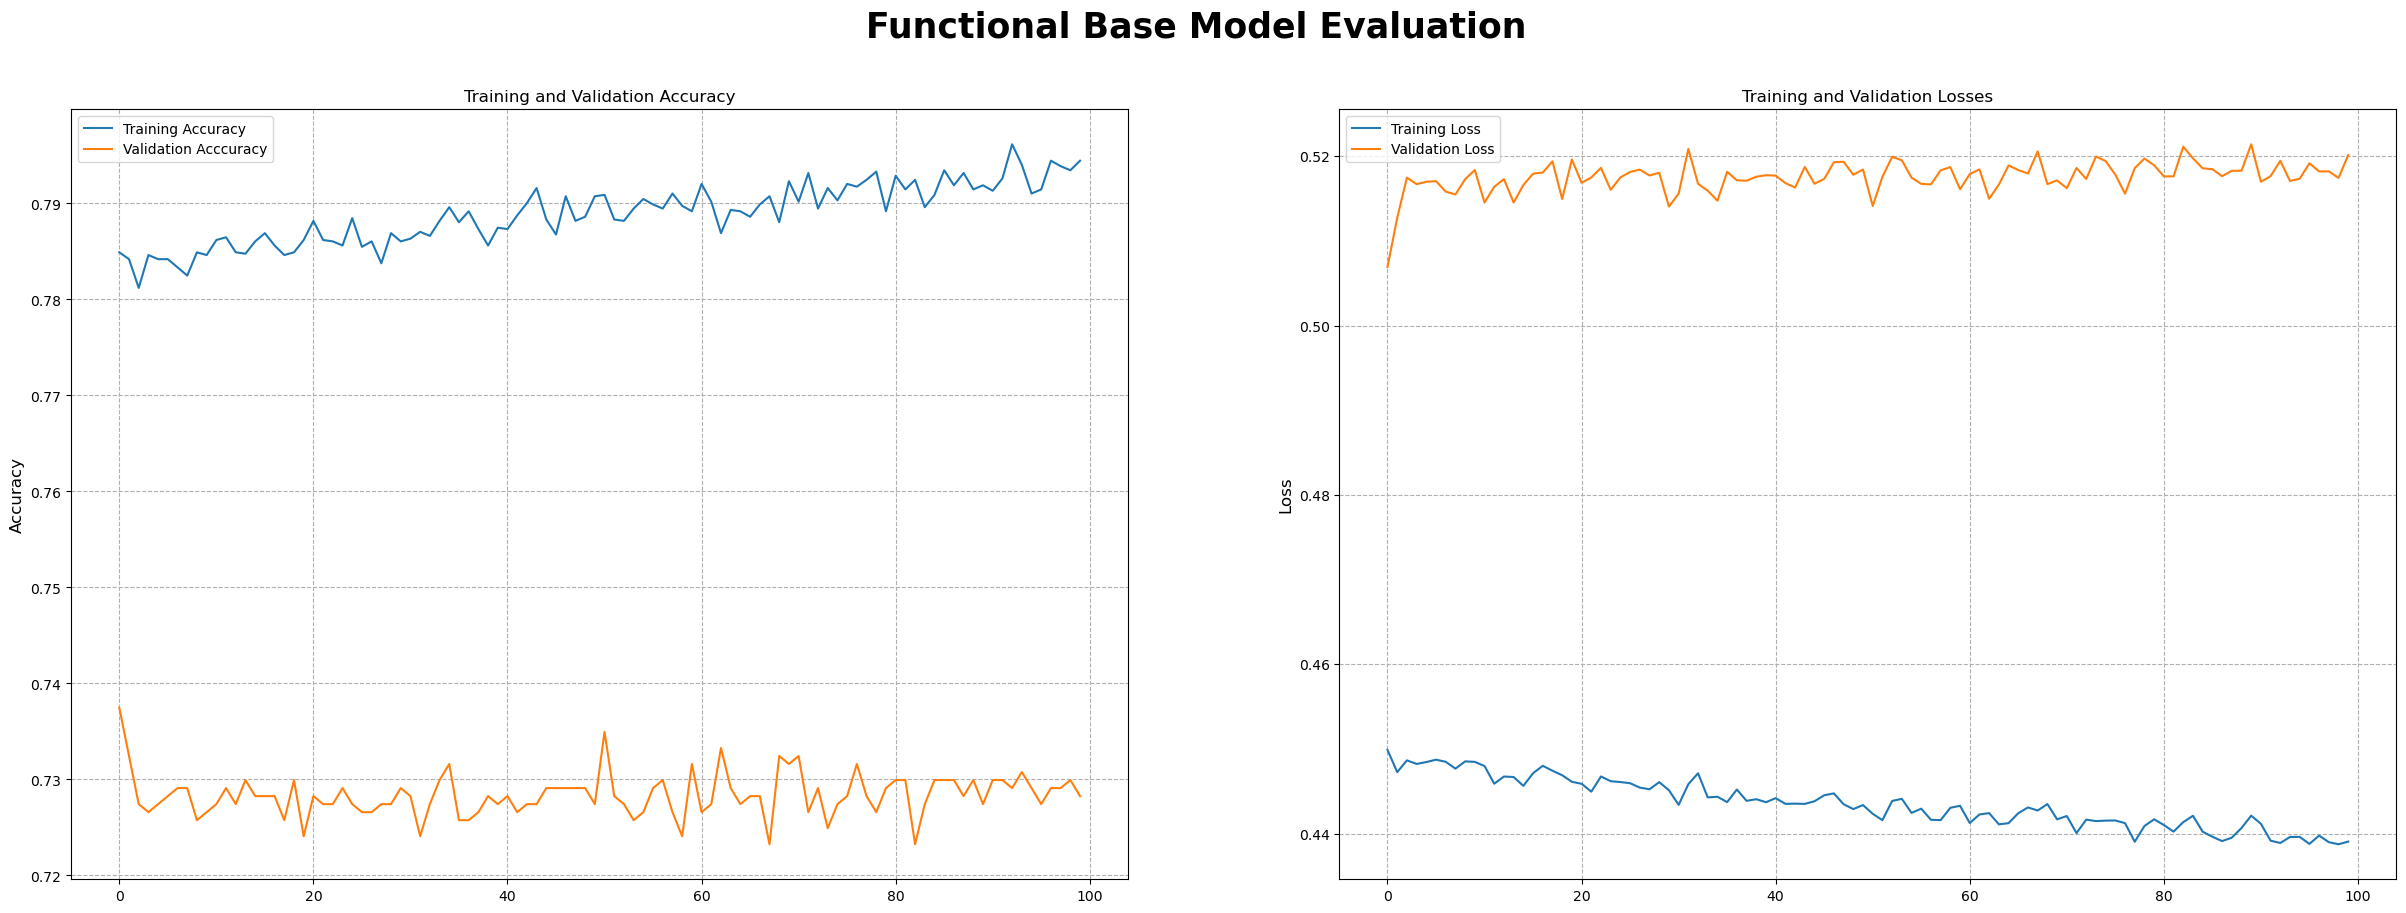

In [375]:
fig, ax = plt.subplots(1,2, figsize=(30,10))
fig.suptitle('Functional Base Model Evaluation', fontsize=25, weight='bold')

plt.subplot(1,2,1)
plt.title("Training and Validation Accuracy", fontsize=12)
plt.plot(history_functional_base.history['accuracy'],label="Training Accuracy")
plt.plot(history_functional_base.history['val_accuracy'], label="Validation Acccuracy")
plt.ylabel("Accuracy", fontsize=12)
plt.legend()
plt.grid(linestyle='--')

plt.subplot(1,2,2)
plt.title("Training and Validation Losses", fontsize=12)
plt.plot(history_functional_base.history['loss'], label="Training Loss")
plt.plot(history_functional_base.history['val_loss'], label="Validation Loss")
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.grid(linestyle='--')

plt.style.use('default')
plt.show()

### Model Improvement

In [376]:
n_neuronfunc = (16, 10)  

# Functional Model Architechture
data_in = Input(shape=(n_feature, ))                # Input Layer

hidden_n = data_in
for n in n_neuronfunc:                              # Hidden Layer
    hidden_n = Dense(n, activation='elu')(hidden_n)

data_out = Dense(1, activation='sigmoid')(hidden_n) # Output Layer

model_func = Model(inputs=data_in, outputs=data_out)

In [377]:
model_func.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 15)]              0         
                                                                 
 dense_18 (Dense)            (None, 16)                256       
                                                                 
 dense_19 (Dense)            (None, 10)                170       
                                                                 
 dense_20 (Dense)            (None, 1)                 11        
                                                                 
Total params: 437
Trainable params: 437
Non-trainable params: 0
_________________________________________________________________


In [378]:
model_func.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics='accuracy')
history_func = model_func.fit(train_dataset, epochs=100, validation_data=(val_dataset))

Epoch 1/100
55/55 [==============================] - 1s 7ms/step - loss: 0.7788 - accuracy: 0.4197 - val_loss: 0.8178 - val_accuracy: 0.3094
Epoch 2/100
55/55 [==============================] - 0s 3ms/step - loss: 0.7390 - accuracy: 0.4556 - val_loss: 0.7584 - val_accuracy: 0.3921
Epoch 3/100
55/55 [==============================] - 0s 3ms/step - loss: 0.7062 - accuracy: 0.5128 - val_loss: 0.7104 - val_accuracy: 0.4908
Epoch 4/100
55/55 [==============================] - 0s 3ms/step - loss: 0.6782 - accuracy: 0.5746 - val_loss: 0.6728 - val_accuracy: 0.5719
Epoch 5/100
55/55 [==============================] - 0s 3ms/step - loss: 0.6542 - accuracy: 0.6365 - val_loss: 0.6427 - val_accuracy: 0.6279
Epoch 6/100
55/55 [==============================] - 0s 3ms/step - loss: 0.6338 - accuracy: 0.6714 - val_loss: 0.6184 - val_accuracy: 0.6572
Epoch 7/100
55/55 [==============================] - 0s 3ms/step - loss: 0.6165 - accuracy: 0.6890 - val_loss: 0.5979 - val_accuracy: 0.6773
Epoch 8/100
5

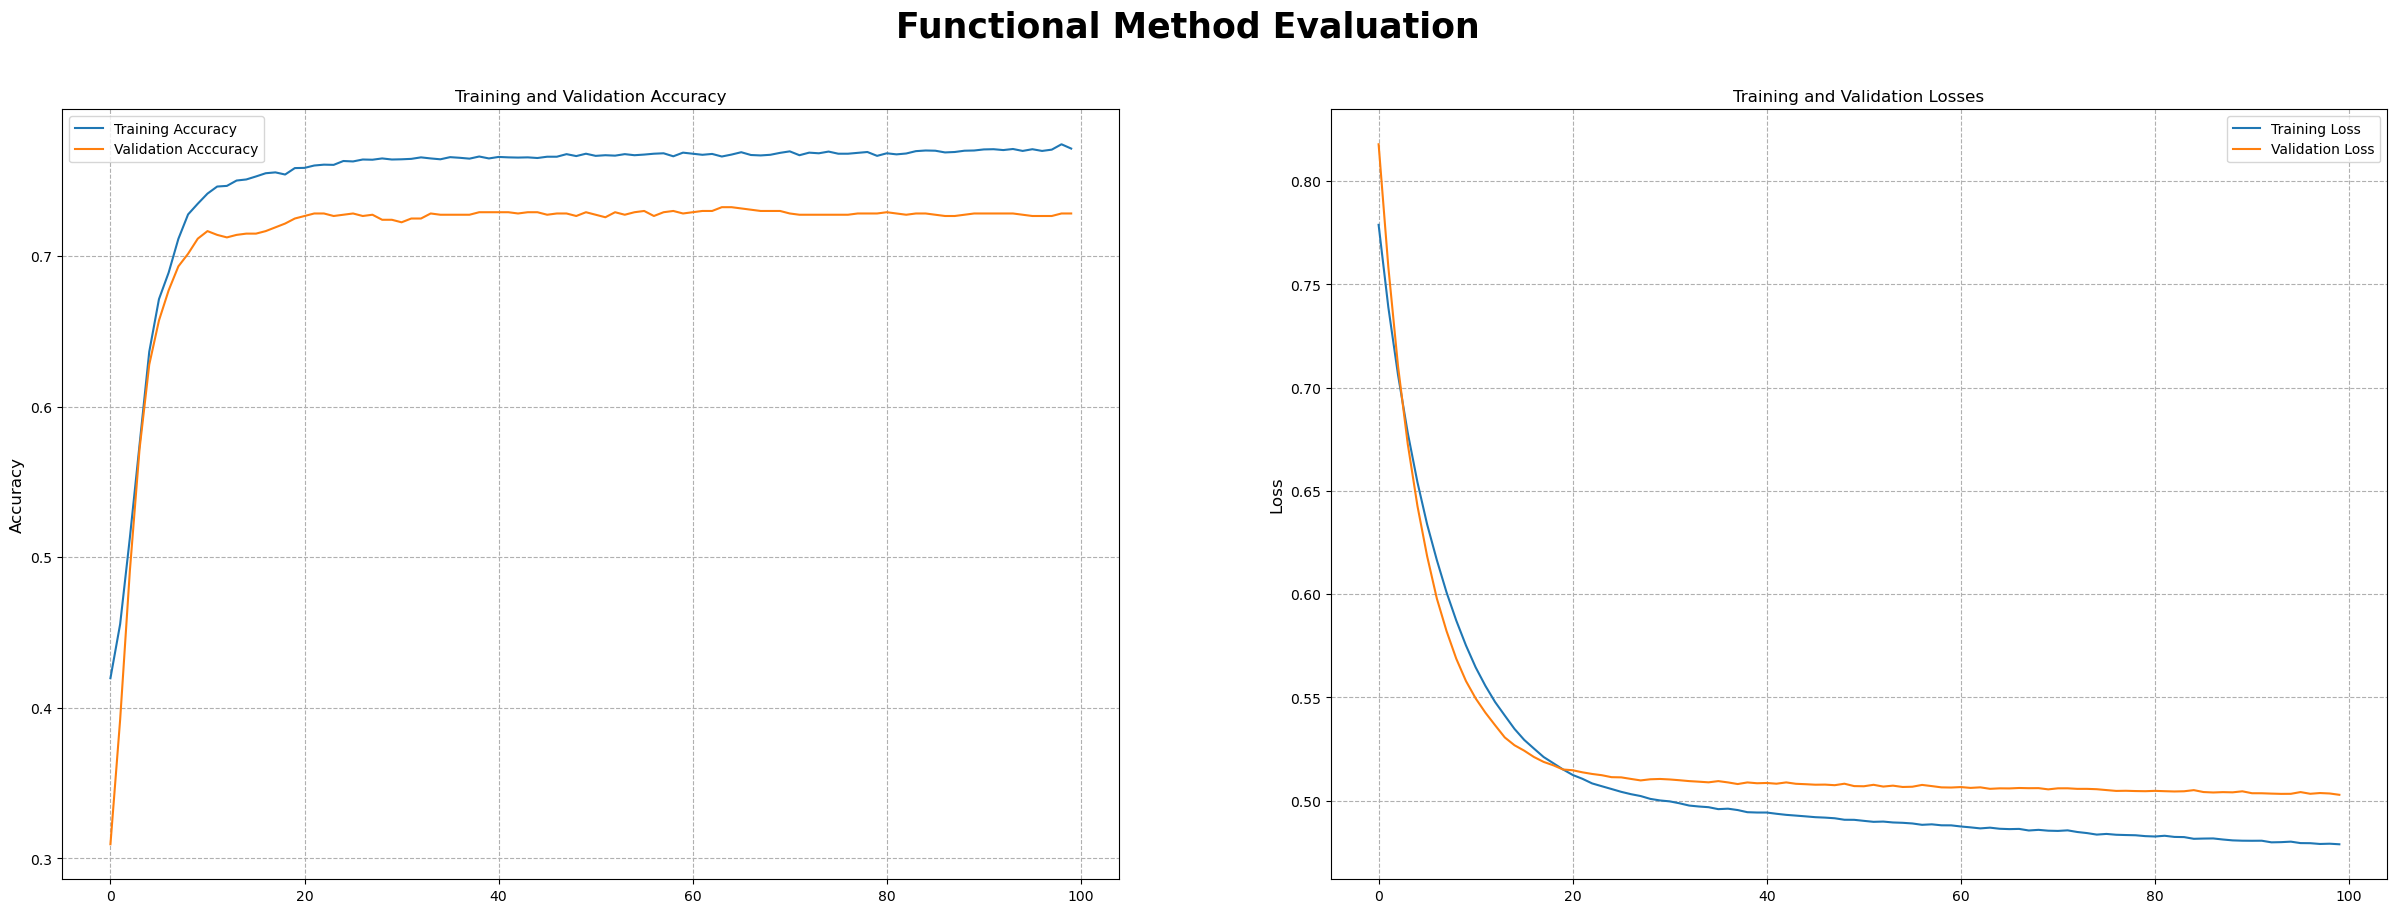

In [379]:
fig, ax = plt.subplots(1,2, figsize=(30,10))
fig.suptitle('Functional Method Evaluation', fontsize=25, weight='bold')

plt.subplot(1,2,1)
plt.title("Training and Validation Accuracy", fontsize=12)
plt.plot(history_func.history['accuracy'],label="Training Accuracy")
plt.plot(history_func.history['val_accuracy'], label="Validation Acccuracy")
plt.ylabel("Accuracy", fontsize=12)
plt.legend()
plt.grid(linestyle='--')

plt.subplot(1,2,2)
plt.title("Training and Validation Losses", fontsize=12)
plt.plot(history_func.history['loss'], label="Training Loss")
plt.plot(history_func.history['val_loss'], label="Validation Loss")
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.grid(linestyle='--')

plt.style.use('default')
plt.show()

### Model Evaluation

9/9 [==============================] - 0s 3ms/step
========== TEST ==========
              precision    recall  f1-score   support

           0       0.92      0.60      0.73       775
           1       0.44      0.86      0.58       280

    accuracy                           0.67      1055
   macro avg       0.68      0.73      0.65      1055
weighted avg       0.80      0.67      0.69      1055



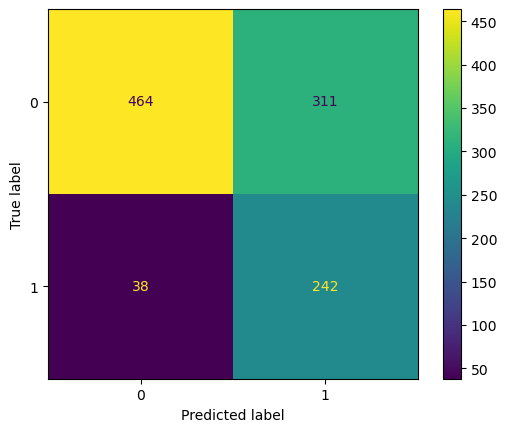

In [381]:
# predict probabilities
y_pred_func = model_func.predict(test_dataset)
y_pred_func = (y_pred_func > 0.4)

# classification report
print("="*10,"TEST","="*10)
print(classification_report(y_test, y_pred_func, zero_division=0))

# confusion matrix
cm = confusion_matrix(y_test, y_pred_func)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='viridis')
plt.show()

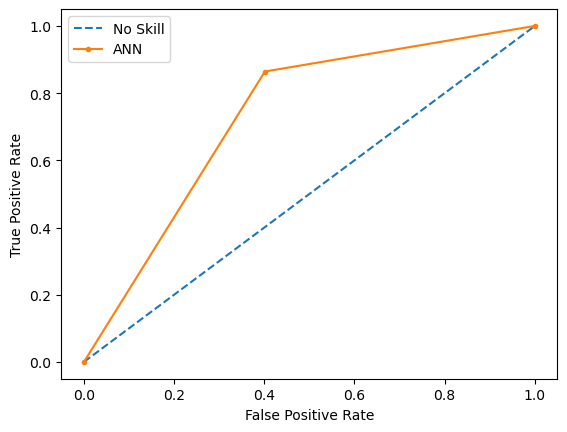

AUC score: 0.7314976958525345


In [382]:
# calculate roc curves & auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_func)
auc = roc_auc_score(y_test, y_pred_func)

# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='ANN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print(f'AUC score: {auc}')

Since we focus on the churning clients, we will be looking at the recall score of the two improved models. This is due to the fact that the company will be focusing on how to increase the retainment of the clients. Even though the model doesn't predict the ones who don't churn that well, it doesn't matter since the company will be focusing on returning the churning clients and thus it will keep those who don't churn keep their loyalty to the company.

By this fact, I will be using the functional model which has the higher recall score of the "1" or the churning clients.

# Model Saving

In [383]:
model_func.save("churn_model")

INFO:tensorflow:Assets written to: churn_model\assets


In [384]:
model_func.save("churn_model.h5")

# Model Inference

In this section, I will be inferencing the model by using sample data from the dataframe.

In [386]:
df_inf

,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
0,No,Yes,Yes,70,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1,Yes,Yes,No,38,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),1
2,No,Yes,No,69,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Electronic check,0
3,No,No,No,58,Yes,DSL,Yes,Yes,Yes,Yes,No,No,One year,Yes,Credit card (automatic),0
4,No,No,No,31,Yes,DSL,Yes,No,Yes,Yes,No,No,Month-to-month,No,Credit card (automatic),1
5,No,No,No,5,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,1
6,Yes,Yes,Yes,71,Yes,DSL,No,Yes,Yes,Yes,No,Yes,One year,Yes,Bank transfer (automatic),0
7,Yes,Yes,No,37,Yes,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,1
8,No,No,No,3,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Credit card (automatic),0
9,Yes,No,No,12,No,Fiber optic,No,Yes,Yes,Yes,No,No,Month-to-month,Yes,Mailed check,1


## Pipeline

### Creating Pipeline

In [389]:
num_col = X_train_num.columns.values
cat_col = X_train_cat.columns.values

num_pipe = Pipeline([
    ('scaling', scaler)
])

cat_pipe = Pipeline([
    ('encoding', enc)
])


preprocess = ColumnTransformer(transformers=[
    ('num', num_pipe, num_col),
    ('cat', cat_pipe, cat_col)
])

preprocess.fit(X_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaling',
                                                  StandardScaler())]),
                                 array(['tenure'], dtype=object)),
                                ('cat',
                                 Pipeline(steps=[('encoding',
                                                  OrdinalEncoder())]),
                                 array(['SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod'],
      dtype=object))])

### Saving Pipeline

In [390]:
pickle.dump(preprocess, open('pipe.pkl', 'wb'))

In [391]:
df_inf_final = preprocess.transform(df_inf)

In [392]:
pred_inf = model_func.predict(df_inf_final)
pred_inf_df = pd.DataFrame(np.round_(pred_inf), columns=['Predicted Churn'])
pred_inf_df

1/1 [==============================] - 0s 104ms/step


,Predicted Churn
0,0.0
1,1.0
2,0.0
3,0.0
4,0.0
5,1.0
6,0.0
7,1.0
8,1.0
9,0.0


In [393]:
pd.concat([df_inf, pred_inf_df], axis=1)

,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn,Predicted Churn
0,No,Yes,Yes,70,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0,0.0
1,Yes,Yes,No,38,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),1,1.0
2,No,Yes,No,69,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Electronic check,0,0.0
3,No,No,No,58,Yes,DSL,Yes,Yes,Yes,Yes,No,No,One year,Yes,Credit card (automatic),0,0.0
4,No,No,No,31,Yes,DSL,Yes,No,Yes,Yes,No,No,Month-to-month,No,Credit card (automatic),1,0.0
5,No,No,No,5,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,1,1.0
6,Yes,Yes,Yes,71,Yes,DSL,No,Yes,Yes,Yes,No,Yes,One year,Yes,Bank transfer (automatic),0,0.0
7,Yes,Yes,No,37,Yes,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,1,1.0
8,No,No,No,3,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Credit card (automatic),0,1.0
9,Yes,No,No,12,No,Fiber optic,No,Yes,Yes,Yes,No,No,Month-to-month,Yes,Mailed check,1,0.0


# Conclusion 

Tensorflow is the model that I used in predicting customer churn of this company. By not using monthly charges, total charges and gender, I created the model which is divided into two: sequential and functional. After the improvement of both models, I find that these two models are almost the same in terms of predicting whether the customer will churn or not. But due to the reasoning of higher recall score, I used functional model to predict the data.